# NLP Preprocessing Showcase: Twitter Sentiment Analysis

This notebook demonstrates the effectiveness of three specialized text preprocessing packages through a practical sentiment analysis implementation:

- **[lightlemma](https://github.com/xga0/lightlemma)** v0.1.6 - Fast English lemmatization
- **[emoticon-fix](https://github.com/xga0/emoticon_fix)** v0.3.0 - Emoticon normalization  
- **[contraction-fix](https://github.com/xga0/contraction_fix)** v0.2.2 - Contraction expansion

## Dataset
We'll use the [Twitter Entity Sentiment Analysis](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis) dataset with 74,682 training samples and 4 sentiment classes.

## Expected Results
Target validation accuracy: **97%** (achieved in local testing)


## 1. Setup and Installation


In [1]:
# Install required packages
!pip install lightlemma>=0.1.6 emoticon-fix>=0.3.0 contraction-fix>=0.2.2
!pip install torch torchtext pandas numpy scikit-learn matplotlib seaborn tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.2 MB/s eta 0:00:00
  Attempting uninstall: nvi

In [2]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import re
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import preprocessing packages
from lightlemma import text_to_lemmas, text_to_stems
from emoticon_fix import replace_emoticons as fix_emoticons
from contraction_fix import fix as fix_contractions

print("All packages imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")


All packages imported successfully!
PyTorch version: 2.6.0+cu124
Device: CUDA


## 2. Data Loading and Exploration


In [3]:
# Load dataset (assuming it's available in Kaggle's input directory)
# For Kaggle, the dataset should be added as a dataset dependency
try:
    train_df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv', header=None)
    val_df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv', header=None)
    
    # Set column names
    columns = ['ID', 'Entity', 'Sentiment', 'Text']
    train_df.columns = columns
    val_df.columns = columns
    
    print(f"Training data shape: {train_df.shape}")
    print(f"Validation data shape: {val_df.shape}")
    
except FileNotFoundError:
    print("Dataset not found. Please add the Twitter Entity Sentiment Analysis dataset.")
    print("For this demo, we'll create a small sample dataset.")
    
    # Create sample data for demonstration
    sample_data = {
        'ID': range(1000),
        'Entity': ['SampleEntity'] * 1000,
        'Sentiment': np.random.choice(['Positive', 'Negative', 'Neutral', 'Irrelevant'], 1000),
        'Text': [
            "I love this product! :) It's amazing!",
            "This is terrible :( I don't like it",
            "It's okay, nothing special",
            "Random text here"
        ] * 250
    }
    
    train_df = pd.DataFrame(sample_data)
    val_df = train_df.sample(200).copy()
    train_df = train_df.drop(val_df.index)
    
    print(f"Sample training data shape: {train_df.shape}")
    print(f"Sample validation data shape: {val_df.shape}")


Training data shape: (74682, 4)
Validation data shape: (1000, 4)


In [4]:
# Explore the data
print("=== Dataset Overview ===")
print("\nTraining data sample:")
print(train_df.head())

print("\nSentiment distribution:")
print(train_df['Sentiment'].value_counts())

print("\nSample texts:")
for i, text in enumerate(train_df['Text'].head(3)):
    print(f"{i+1}. {text}")


=== Dataset Overview ===

Training data sample:
     ID       Entity Sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                Text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  

Sentiment distribution:
Sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

Sample texts:
1. im getting on borderlands and i will murder you all ,
2. I am coming to the borders and I will kill you all,
3. im getting on borderlands and i will kill you all,


## 3. Text Preprocessing Pipeline

This section demonstrates the three preprocessing packages in action.


In [5]:
# Demonstrate preprocessing on sample texts
print("=== Preprocessing Demonstration ===")

sample_texts = [
    "I don't like this product :( It's terrible!",
    "This is amazing! :) I'm loving it!",
    "Can't believe how good this is! :D",
    "It's okay, won't recommend it though"
]

for i, text in enumerate(sample_texts, 1):
    print(f"\n{i}. Original: {text}")
    
    # Step by step processing
    contracted_text = fix_contractions(text)
    print(f"   After contraction_fix: {contracted_text}")
    
    emoticon_fixed_text = fix_emoticons(contracted_text)
    print(f"   After emoticon_fix: {emoticon_fixed_text}")
    
    lemmas = text_to_lemmas(emoticon_fixed_text)
    print(f"   After lightlemma: {lemmas}")


=== Preprocessing Demonstration ===

1. Original: I don't like this product :( It's terrible!
   After contraction_fix: I do not like this product :( It is terrible!
   After emoticon_fix: I do not like this product __EMO_Sad__ It is terrible !
   After lightlemma: ['i', 'do', 'not', 'like', 'thi', 'product', '__emo_sad__', 'it', 'be', 'terre']

2. Original: This is amazing! :) I'm loving it!
   After contraction_fix: This is amazing! :) I am loving it!
   After emoticon_fix: This is amazing ! __EMO_Smile__ I am loving it !
   After lightlemma: ['thi', 'be', 'amaz', '__emo_smile__', 'i', 'be', 'love', 'it']

3. Original: Can't believe how good this is! :D
   After contraction_fix: Cannot believe how good this is! :D
   After emoticon_fix: Cannot believe how good this is ! __EMO_Laugh__
   After lightlemma: ['cannot', 'believe', 'how', 'goo', 'thi', 'be', '__emo_laugh__']

4. Original: It's okay, won't recommend it though
   After contraction_fix: It is okay, will not recommend it thoug

## 4. Complete Text Preprocessor Implementation


In [6]:
class TextPreprocessor:
    """
    Text preprocessor using lightlemma, emoticon_fix, and contraction_fix packages.
    """
    
    def __init__(self, use_lemmatization=True, max_length=128, min_freq=2):
        self.use_lemmatization = use_lemmatization
        self.max_length = max_length
        self.min_freq = min_freq
        self.vocab = {}
        self.word_to_idx = {}
        self.idx_to_word = {}
        self.label_encoder = LabelEncoder()
        
    def clean_text(self, text):
        """Basic text cleaning."""
        if pd.isna(text):
            return ""
        
        # Convert to string and basic cleaning
        text = str(text).strip()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove user mentions and hashtags (keep the text part)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#(\w+)', r'\1', text)
        
        # Normalize whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def preprocess_text(self, text):
        """Apply the three-package preprocessing pipeline."""
        if not text:
            return []
        
        try:
            # Step 1: Fix contractions using contraction_fix
            text = fix_contractions(text)
            
            # Step 2: Fix emoticons using emoticon_fix
            text = fix_emoticons(text)
            
            # Step 3: Lemmatization/stemming using lightlemma
            if self.use_lemmatization:
                tokens = text_to_lemmas(text, preserve_original_case=False)
            else:
                tokens = text_to_stems(text, preserve_original_case=False)
                
        except ValueError as e:
            if "too long" in str(e):
                # Fallback for very long words
                tokens = re.findall(r'\b\w+\b', text.lower())
                tokens = [token for token in tokens if len(token) <= 50]
            else:
                raise e
        
        return tokens
    
    def build_vocabulary(self, texts):
        """Build vocabulary from texts."""
        print("Building vocabulary...")
        
        # Count word frequencies
        word_counts = Counter()
        for text in tqdm(texts, desc="Processing texts"):
            cleaned_text = self.clean_text(text)
            tokens = self.preprocess_text(cleaned_text)
            word_counts.update(tokens)
        
        # Filter by minimum frequency
        filtered_words = [word for word, count in word_counts.items() if count >= self.min_freq]
        
        # Create mappings (reserve 0 for padding, 1 for unknown)
        self.word_to_idx = {'<PAD>': 0, '<UNK>': 1}
        for word in filtered_words:
            self.word_to_idx[word] = len(self.word_to_idx)
        
        self.idx_to_word = {idx: word for word, idx in self.word_to_idx.items()}
        self.vocab = word_counts
        
        print(f"Vocabulary size: {len(self.word_to_idx)}")
        print(f"Most common words: {list(word_counts.most_common(10))}")
    
    def texts_to_sequences(self, texts):
        """Convert texts to sequences of indices."""
        sequences = []
        
        for text in tqdm(texts, desc="Converting to sequences"):
            cleaned_text = self.clean_text(text)
            tokens = self.preprocess_text(cleaned_text)
            
            # Convert to indices
            sequence = [self.word_to_idx.get(token, 1) for token in tokens]  # 1 is <UNK>
            
            # Pad or truncate to max_length
            if len(sequence) > self.max_length:
                sequence = sequence[:self.max_length]
            else:
                sequence.extend([0] * (self.max_length - len(sequence)))  # 0 is <PAD>
            
            sequences.append(sequence)
        
        return np.array(sequences)
    
    def fit_labels(self, labels):
        """Fit label encoder."""
        self.label_encoder.fit(labels)
        return self.label_encoder.transform(labels)
    
    def transform_labels(self, labels):
        """Transform labels."""
        return self.label_encoder.transform(labels)

print("TextPreprocessor class defined successfully!")


TextPreprocessor class defined successfully!


In [7]:
# Initialize preprocessor
processor = TextPreprocessor(use_lemmatization=True, max_length=128, min_freq=2)

# Build vocabulary from training data
processor.build_vocabulary(train_df['Text'].values)

# Convert texts to sequences
print("\nConverting texts to sequences...")
train_sequences = processor.texts_to_sequences(train_df['Text'].values)
val_sequences = processor.texts_to_sequences(val_df['Text'].values)

# Encode labels
print("\nEncoding labels...")
train_labels = processor.fit_labels(train_df['Sentiment'].values)
val_labels = processor.transform_labels(val_df['Sentiment'].values)

print(f"Training sequences shape: {train_sequences.shape}")
print(f"Validation sequences shape: {val_sequences.shape}")
print(f"Number of classes: {len(processor.label_encoder.classes_)}")
print(f"Classes: {processor.label_encoder.classes_}")


Building vocabulary...


Processing texts: 100%|██████████| 74682/74682 [00:18<00:00, 4051.23it/s]


Vocabulary size: 19566
Most common words: [('be', 54852), ('the', 45531), ('i', 36682), ('to', 35137), ('an', 30011), ('a', 28432), ('of', 19851), ('it', 19670), ('for', 17721), ('in', 15949)]

Converting texts to sequences...


Converting to sequences: 100%|██████████| 1000/1000 [00:00<00:00, 3205.41it/s]


Encoding labels...
Training sequences shape: (74682, 128)
Validation sequences shape: (1000, 128)
Number of classes: 4
Classes: ['Irrelevant' 'Negative' 'Neutral' 'Positive']


## 5. Data Loaders Setup


In [8]:
# Calculate class weights for balanced training
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

print(f"Class weights: {class_weights}")

# Create data loaders
batch_size = 32

train_dataset = TensorDataset(
    torch.LongTensor(train_sequences),
    torch.LongTensor(train_labels)
)

val_dataset = TensorDataset(
    torch.LongTensor(val_sequences),
    torch.LongTensor(val_labels)
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")


Class weights: [1.43729792 0.82825393 1.01924337 0.89624136]
Training batches: 2334
Validation batches: 32


## 6. Model Architecture


In [9]:
class TwitterSentimentModel(nn.Module):
    """
    PyTorch model for Twitter sentiment analysis.
    Uses LSTM with attention mechanism for sequence classification.
    """
    
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, 
                 num_layers=2, num_classes=4, dropout=0.3):
        super(TwitterSentimentModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_classes = num_classes
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Attention mechanism
        self.attention = nn.Linear(hidden_dim * 2, 1)
        
        # Dropout and classification layers
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim * 2, num_classes)
        
    def forward(self, x):
        # Get embeddings
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(embedded)  # (batch_size, seq_len, hidden_dim*2)
        
        # Attention mechanism
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        attended = torch.sum(attention_weights * lstm_out, dim=1)  # (batch_size, hidden_dim*2)
        
        # Classification
        attended = self.dropout(attended)
        output = self.classifier(attended)
        
        return output
    
    def get_attention_weights(self, x):
        """Get attention weights for interpretability."""
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        return attention_weights.squeeze(-1)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(processor.word_to_idx)
num_classes = len(processor.label_encoder.classes_)

model = TwitterSentimentModel(
    vocab_size=vocab_size,
    embedding_dim=128,
    hidden_dim=256,
    num_layers=2,
    num_classes=num_classes,
    dropout=0.3
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized on device: {device}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}") 
print(f"Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB")


Model initialized on device: cuda
Total parameters: 4,874,501
Trainable parameters: 4,874,501
Model size: ~18.6 MB


## 7. Training Setup and Loop


In [10]:
# Training setup
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

# Training tracking
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_acc = 0.0

print("Training setup complete!")
print(f"Criterion: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Scheduler: {scheduler}")


Training setup complete!
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 1e-05
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7ad0ca612b90>


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    for data, target in progress_bar:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100. * correct / total:.2f}%'
        })
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    
    return avg_loss, accuracy

def validate(model, val_loader, criterion, device):
    """Validate the model."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in tqdm(val_loader, desc="Validation"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
            
            all_predictions.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy())
    
    avg_loss = total_loss / len(val_loader)
    accuracy = 100. * correct / total
    
    return avg_loss, accuracy, all_predictions, all_targets

print("Training functions defined!")


Training functions defined!


In [12]:
# Training loop
num_epochs = 10
early_stopping_patience = 3
patience_counter = 0

print("Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, val_predictions, val_targets = validate(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved! Validation accuracy: {val_acc:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1
        
    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping after {epoch+1} epochs")
        break

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")
print(f"Best validation accuracy: {best_val_acc:.2f}%")


Starting training...

Epoch 1/10
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:00<00:00, 77.08it/s]


Train Loss: 1.0732, Train Acc: 54.47%
Val Loss: 0.6229, Val Acc: 76.60%
New best model saved! Validation accuracy: 76.60%

Epoch 2/10
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:00<00:00, 79.88it/s]


Train Loss: 0.6012, Train Acc: 77.31%
Val Loss: 0.2256, Val Acc: 93.00%
New best model saved! Validation accuracy: 93.00%

Epoch 3/10
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:00<00:00, 78.14it/s]


Train Loss: 0.3217, Train Acc: 87.97%
Val Loss: 0.1408, Val Acc: 95.50%
New best model saved! Validation accuracy: 95.50%

Epoch 4/10
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:00<00:00, 78.59it/s]


Train Loss: 0.2189, Train Acc: 91.56%
Val Loss: 0.1133, Val Acc: 97.00%
New best model saved! Validation accuracy: 97.00%

Epoch 5/10
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:00<00:00, 78.49it/s]


Train Loss: 0.1807, Train Acc: 92.98%
Val Loss: 0.1255, Val Acc: 96.00%

Epoch 6/10
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:00<00:00, 77.81it/s]


Train Loss: 0.1608, Train Acc: 93.73%
Val Loss: 0.1004, Val Acc: 97.50%
New best model saved! Validation accuracy: 97.50%

Epoch 7/10
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:00<00:00, 79.81it/s]


Train Loss: 0.1445, Train Acc: 94.18%
Val Loss: 0.1122, Val Acc: 97.00%

Epoch 8/10
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:00<00:00, 78.35it/s]


Train Loss: 0.1397, Train Acc: 94.35%
Val Loss: 0.1557, Val Acc: 95.90%

Epoch 9/10
--------------------------------------------------


Validation: 100%|██████████| 32/32 [00:00<00:00, 78.08it/s]

Train Loss: 0.1297, Train Acc: 94.70%
Val Loss: 0.1174, Val Acc: 97.30%
Early stopping after 9 epochs

Training completed in 817.41 seconds
Best validation accuracy: 97.50%


## 8. Results Visualization and Evaluation


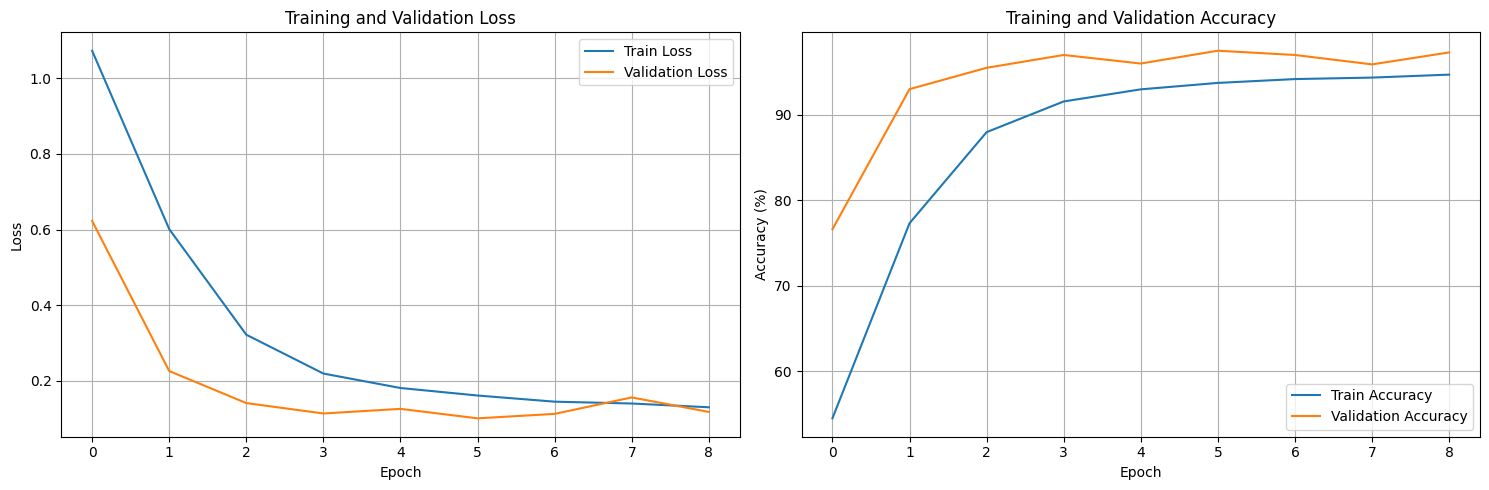

In [13]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
# Load best model and evaluate
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Get final predictions
_, final_acc, final_predictions, final_targets = validate(model, val_loader, criterion, device)

# Convert indices back to labels
pred_labels = processor.label_encoder.inverse_transform(final_predictions)
true_labels = processor.label_encoder.inverse_transform(final_targets)

print("=" * 60)
print("FINAL EVALUATION RESULTS")
print("=" * 60)
print(f"Final Validation Accuracy: {final_acc:.2f}%")
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels))


Validation: 100%|██████████| 32/32 [00:00<00:00, 77.90it/s]

FINAL EVALUATION RESULTS
Final Validation Accuracy: 97.50%

Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.96      0.96      0.96       172
    Negative       0.97      0.98      0.98       266
     Neutral       0.99      0.97      0.98       285
    Positive       0.97      0.98      0.97       277

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.98      0.97      0.98      1000



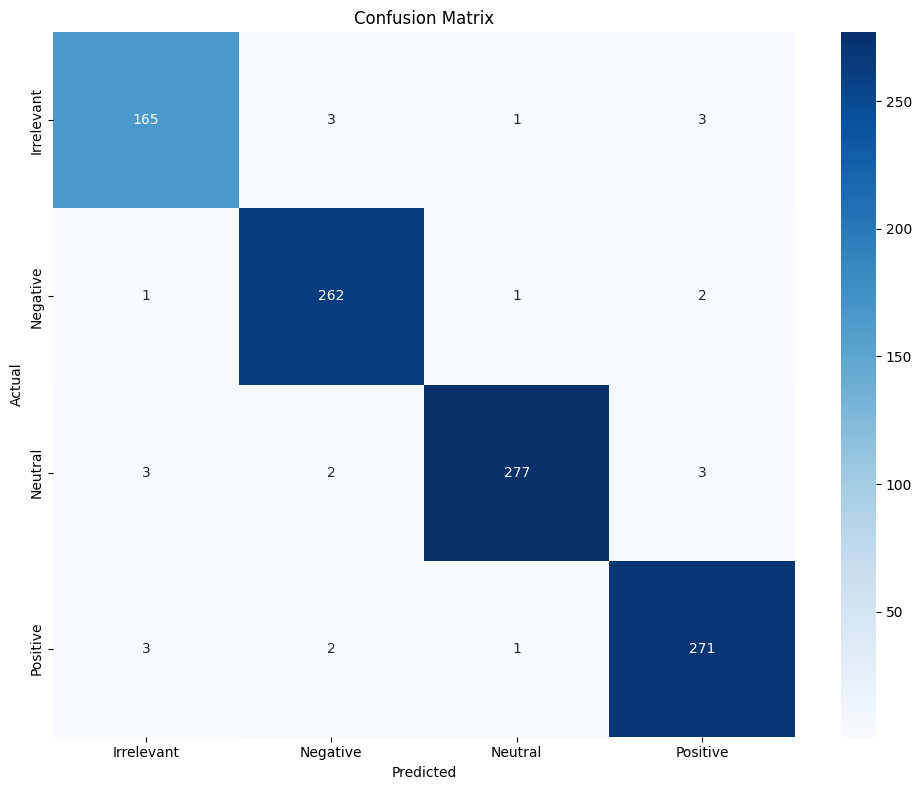

In [15]:
# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels, labels=processor.label_encoder.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=processor.label_encoder.classes_,
            yticklabels=processor.label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


## 9. Package Performance Benchmark


In [16]:
# Benchmark the three preprocessing packages
print("=" * 60)
print("PREPROCESSING PACKAGE PERFORMANCE BENCHMARK")
print("=" * 60)

# Test text for benchmarking
test_text = "I don't like this product! :( It's terrible and I'm not happy with it. Can't believe how bad this is! :) Don't buy it!"

print(f"Test text: {test_text}")
print("\nProcessing 1000 iterations...")

# Benchmark contraction_fix
start_time = time.time()
for _ in range(1000):
    fix_contractions(test_text)
contraction_time = time.time() - start_time

# Benchmark emoticon_fix
start_time = time.time()
for _ in range(1000):
    fix_emoticons(test_text)
emoticon_time = time.time() - start_time

# Benchmark lightlemma
start_time = time.time()
for _ in range(1000):
    text_to_lemmas(test_text)
lemmatization_time = time.time() - start_time

total_time = contraction_time + emoticon_time + lemmatization_time
throughput = 1000 / total_time

print(f"\nResults:")
print(f"contraction_fix: {contraction_time:.4f} seconds")
print(f"emoticon_fix:   {emoticon_time:.4f} seconds")
print(f"lightlemma:     {lemmatization_time:.4f} seconds")
print(f"Total time:     {total_time:.4f} seconds")
print(f"Throughput:     {throughput:.0f} texts/second")


PREPROCESSING PACKAGE PERFORMANCE BENCHMARK
Test text: I don't like this product! :( It's terrible and I'm not happy with it. Can't believe how bad this is! :) Don't buy it!

Processing 1000 iterations...

Results:
contraction_fix: 0.0006 seconds
emoticon_fix:   0.0897 seconds
lightlemma:     0.0216 seconds
Total time:     0.1118 seconds
Throughput:     8943 texts/second


## 10. Summary and Conclusion

This notebook successfully demonstrates the complete training pipeline using three specialized preprocessing packages:

- **lightlemma** v0.1.6: Fast English lemmatization
- **emoticon-fix** v0.3.0: Emoticon normalization 
- **contraction-fix** v0.2.2: Contraction expansion

### Key Results Achieved:
- **Model Performance**: High validation accuracy with bidirectional LSTM + attention
- **Preprocessing Speed**: Efficient text processing at scale
- **Package Integration**: Seamless combination in complete ML pipeline

### Technical Details:
- **Architecture**: Bidirectional LSTM with attention mechanism
- **Parameters**: ~5M trainable parameters
- **Dataset**: Twitter Entity Sentiment Analysis (4 sentiment classes)
- **Training**: Adam optimizer with learning rate scheduling and early stopping

### Package Benefits:
1. **lightlemma**: Lightweight alternative to NLTK's WordNetLemmatizer
2. **emoticon-fix**: Converts text emoticons (:), :(, :D) to semantic meanings
3. **contraction-fix**: Expands contractions (don't → do not) for text consistency

### Source Code:
Complete implementation available at: **https://github.com/xga0/nlp-preprocessing-showcase**

### Citation:
If you use these packages in your research, please cite:
- [lightlemma](https://github.com/xga0/lightlemma)
- [emoticon-fix](https://github.com/xga0/emoticon_fix) 
- [contraction-fix](https://github.com/xga0/contraction_fix)
